In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect, brentq
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)

In [2]:
class Dynamics:
    pass

In [3]:
class Contract:
    pass

In [4]:
class MC:
    pass

## Problem 1

In [5]:
# your solution should allow for minor perturbations of the parameters, 
# but you may assume that r>0 and that S0=K 

p1dynamics=Dynamics()
p1dynamics.S0 = 88
p1dynamics.r = 0.03

In [6]:
p1contract=Contract() 
p1contract.K = 88 
p1contract.T = 1.0 

p1contract.observedPrice = 0.5  
#this assumes that the contract pays $1 (or nothing).  
#If instead you assume it pays $20 million, then this observed price needs to be changed to $10 million.

In [7]:
def BScallPrice(sigma,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*(F*norm.cdf(d1)-K*norm.cdf(d2))

def BSputPrice(sigma,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*K*norm.cdf(-d2)-F*norm.cdf(-d1)

In [8]:
def BS_binary_call(sigma,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*norm.cdf(d2)

def BS_binary_put(sigma,S,rGrow,r,K,T):
    F=S*np.exp(rGrow*T)
    sd = sigma*np.sqrt(T)
    d1 = np.log(F/K)/sd+sd/2
    d2 = d1-sd
    return np.exp(-r*T)*norm.cdf(-d2)

In [9]:
def impliedVolOfBet(contract,dynamics):

    if contract.K != dynamics.S0:
        raise ValueError('Please assume the ATM case')
        
    if dynamics.r <= 0: 
        raise ValueError('Please assume r>0')
        
    # fill this in.  You may use a root-finder, but if you see a way to code this without using a root-finder, 
    # then you are not required to use a root-finder.
    
    # ----------
    S,rGrow,r,K,T = dynamics.S0, 0, dynamics.r, contract.K, contract.T
    C = contract.observedPrice
    hi=0.01
    while BS_binary_put(hi,S,rGrow,r,K,T)>C:
        hi=hi/2
    while BS_binary_put(hi,S,rGrow,r,K,T)<C:
        hi=hi*2
    lo=hi/2
    
    def optim(sigma):
        return BS_binary_put(sigma,S,rGrow,r,K,T)-C
    
    impliedVol = bisect(optim, lo, hi)
    # ----------
    
    return impliedVol    

In [10]:
impliedVol = impliedVolOfBet(p1contract,p1dynamics)
print(impliedVol)

0.07635674128890968


In [11]:
dsigma = 1e-9
sigma_d = impliedVol-dsigma
sigma_u = impliedVol+dsigma
S = p1dynamics.S0
rGrow = 0
r = p1dynamics.r
K = p1contract.K
T = p1contract.T

bp_d = BS_binary_put(sigma_d,S,rGrow,r,K,T)
bp_u = BS_binary_put(sigma_u,S,rGrow,r,K,T)

vega = (bp_u-bp_d) / (2*dsigma)
print(vega)

0.19343485146983141


In [12]:
BS_binary_put(impliedVol,S,rGrow,r,K,T)

0.5000000000000866

## 1b.

Long Gigantic Rebirth's Binary Put -> vega > 0 -> Long volatility 

## Problem 3

In [13]:
S0 = 10
S0*(2*norm.cdf(0)-1)

0.0

In [14]:
S0*np.sqrt(T)*norm.pdf(0)

3.989422804014327

In [15]:
S0*(2*norm.cdf(1e-15*np.sqrt(T)/2)-1)

4.440892098500626e-15

In [16]:
S0*np.sqrt(T)*norm.pdf(0)*1e-15

3.989422804014327e-15

Close enough within O(1)

## Problem 4

In [17]:
p4dynamics=Dynamics()
p4dynamics.sigma = 0.70
p4dynamics.S0 = 10
p4dynamics.r = 0.02

In [18]:
p4contract=Contract()
p4contract.K1low = 10
p4contract.K1mid = 11
p4contract.K1high = 14
p4contract.T0 = 0.5
p4contract.T1 = 1.0
p4contract.K0 = 12

In [19]:
p4MC=MC()
p4MC.M = 100000  # Number of paths
p4MC.seed = 0  # Seeding the random number generator with a specified number helps make the calculations reproducible

In [20]:
def price_twostep_contract(contract,dynamics,MC):

    np.random.seed(MC.seed)  #seed the random number generator
    
    # You complete the coding of this function
    
    # ------------------------------------------
    
    K1low, K1mid, K1high = contract.K1low, contract.K1mid, contract.K1high
    T0, T1, T0Barr = contract.T0, contract.T1, contract.K0
    sigma, S0, r = dynamics.sigma, dynamics.S0, dynamics.r
    M = MC.M
    DEBUG = False
    
    # MC needs 2 time steps
    # log(S)=X is normal. Simulate X.
    X = np.ones(M)*np.log(S0)
    
    if DEBUG: print((r-sigma**2/2)*T0)
    X_T0 =    X + (r-sigma**2/2)*T0 + sigma*np.sqrt(T0)*np.random.randn(M)
    
    # Increment X from T0->T1
    dt = T1-T0
    X_T1 = X_T0 + (r-sigma**2/2)*dt + sigma*np.sqrt(dt)*np.random.randn(M)
    
    if DEBUG: print(X, X_T0, X_T1, sep='\n')
    
    # Transform back into prices
    S, S_T0, S_T1 = (np.exp(x) for x in [X, X_T0, X_T1])
    if DEBUG: print(S, S_T0, S_T1, sep='\n')
    
    over_barr = S_T0>T0Barr # Check if S_0.5>12
    over_K1high = S_T1>K1high # Check if S_1>14
    over_mask = (over_barr | over_K1high) # OR meaning use high strike
    neither_mask = ~over_mask # neither conditions meaning use low strike
    
    if DEBUG: print(over_barr.sum(), over_K1high.sum(), neither_mask.sum(), sep='\n')
    
    C_over = np.maximum(S_T1[over_mask]-K1mid,0) # Struck at high K=11
    C_neither = np.maximum(S_T1[neither_mask]-K1low,0) # Struck at low K=10
    
    C = np.append(C_over, C_neither) # Combined payoffs
    C_0 = np.exp(-r*T1)*C # PV of payoff
    if DEBUG: print(C)
    
    price = np.mean(C_0)
    standard_error = np.std(C_0, ddof=1) / np.sqrt(M)
    
    return price, standard_error, C, S_T1
    # ------------------------------------------        

In [21]:
(price, standard_error, C, S) =  price_twostep_contract(p4contract,p4dynamics,p4MC)
print(price, standard_error)

2.555764775512144 0.019444258715870077


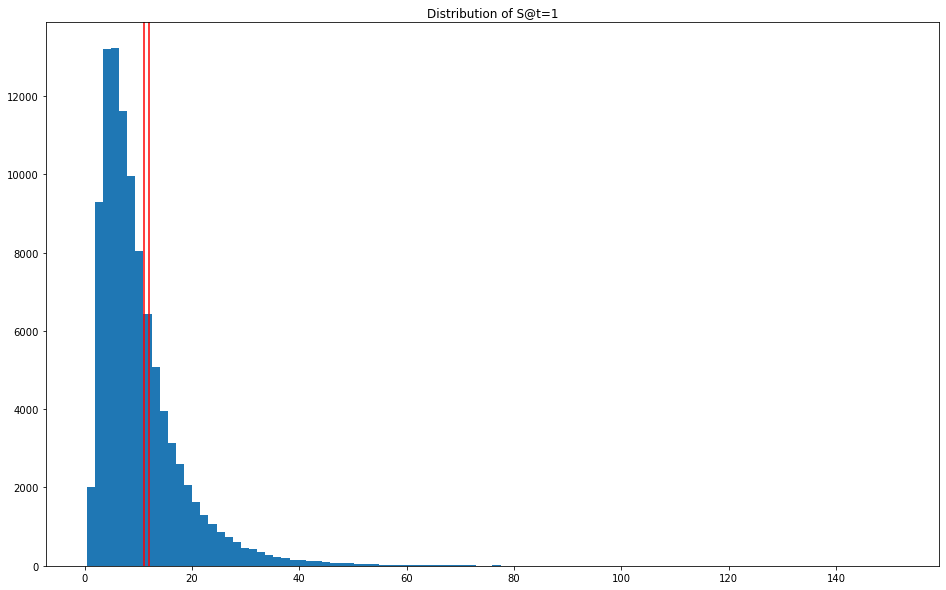

In [22]:
p = plt.hist(S, bins=100)
plt.title("Distribution of S@t=1")
plt.axvline(11, color='r')
plt.axvline(12, color='r')
plt.show()

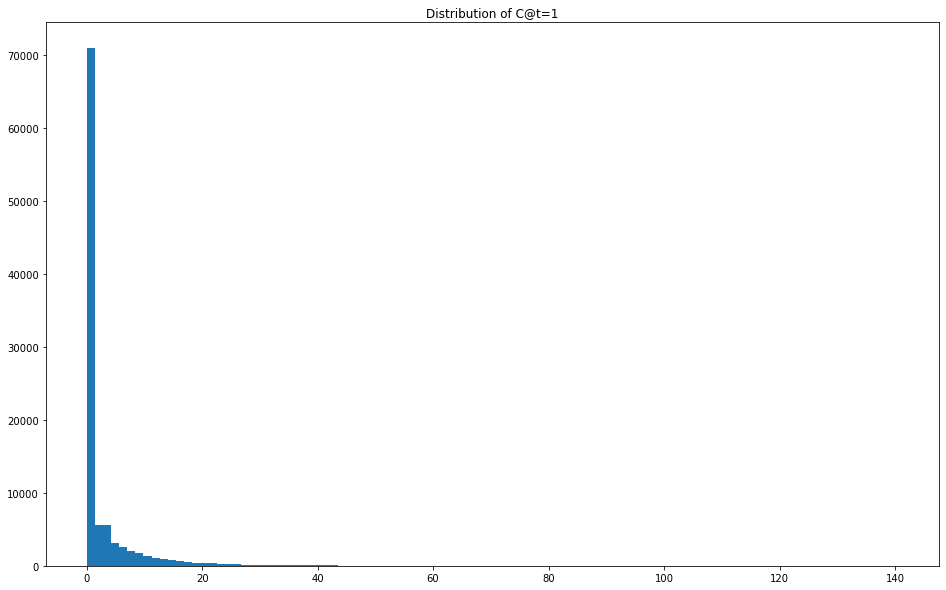

In [23]:
p = plt.hist(C, bins=100)
plt.title("Distribution of C@t=1")
plt.show()